Following http://rebound.readthedocs.io/en/latest/ipython/OrbitalElements.html note that by default any orbital elements that can be set to zero are.

By default, REBOUND using Jacobi elements, which for each particle are always referenced to the center of mass of all particles with lower index in the simulation.

Now add a distant planet on a circular orbit:

In [15]:
from __future__ import division, print_function
import rebound
import numpy as np
import matplotlib.pyplot as plt

In [18]:
sim = rebound.Simulation()
sim.units = ('day', 'AU', 'Msun')

# Set up a binary
sim.add(m=1.)
sim.add(m=0.8, a=0.2)

sim.move_to_com()

# Add a CBP on a circular orbit
# N.b. this sets up the planet relative to the binary center of mass. 
# This is what we want for the circumbinary case.
# For the circumprimary case, we might want to explicitly pass the primary. 
# That's in the docs.
sim.add(m=1e-8, a=0.4)

sim.move_to_com()

sim.status()

---------------------------------
REBOUND version:     	3.5.2
REBOUND built on:    	Jul 15 2017 11:26:49
Number of particles: 	3
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.001000
---------------------------------
<rebound.Particle object, m=1.0 x=-0.0888888911111111 y=0.0 z=0.0 vx=0.0 vy=-0.022936132136062014 vz=0.0>
<rebound.Particle object, m=0.8 x=0.11111110888888891 y=0.0 z=0.0 vx=0.0 vy=0.028670164713937983 vz=0.0>
<rebound.Particle object, m=1e-08 x=0.39999999777777784 y=0.0 z=0.0 vx=0.0 vy=0.036491162353196625 vz=0.0>
---------------------------------


Verify we have an idea of what's happening... (e.g., can see below that the orbits are prograde, and coplanar)

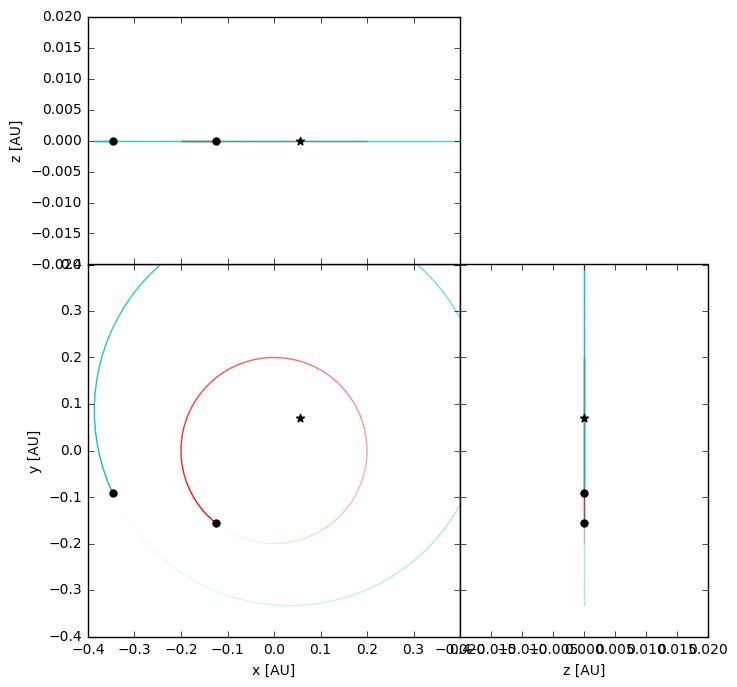

In [20]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
sim.move_to_com()
for i in range(20):
    sim.integrate(sim.t+1)

    plt.grid(True)

    fig = rebound.OrbitPlot(sim,slices=True,color=True,unitlabel="[AU]",lim=0.4,limz=0.02)
    display(fig)
    plt.close(fig)
    clear_output(wait=True)

In [21]:
sim.status()

---------------------------------
REBOUND version:     	3.5.2
REBOUND built on:    	Jul 15 2017 11:26:49
Number of particles: 	3
Selected integrator: 	ias15
Simulation time:     	4.0000000000000000e+01
Current timestep:    	0.523246
---------------------------------
<rebound.Particle object, m=1.0 x=0.05549887243629582 y=0.06943421319918627 z=0.0 vx=-0.01791621315761174 vy=0.014320456361151424 vz=0.0>
<rebound.Particle object, m=0.8 x=-0.06937358551885241 y=-0.08679276447665858 z=0.0 vx=0.022395266263793703 vy=-0.017900570061606665 vz=0.0>
<rebound.Particle object, m=1e-08 x=-0.40212138734504027 y=-0.161785938512133 z=0.0 vx=0.014657677761407301 vy=-0.031186608879831667 vz=0.0>
---------------------------------


So our coplanar, prograde 3 body simulation is running.

Now follow https://github.com/hannorein/rebound/blob/master/ipython_examples/TransitTimingVariations.ipynb.

We're now going to integrate the system forward in time. We assume the observer of the system is in the direction of the positive x-axis. We want to meassure the time when the inner planet transits.

In the single star, single planet geometry, this happens when the y coordinate of the planet changes sign (negative to positive in y, or just when the sign change happens and x is greater than 0). It's a bit trickier when you have $>=3$ bodies in the system, because the condition becomes (e.g. if we're interested in the transit of body 1 in front of body 0):

\begin{equation}
    (y_1 - y_0)_{\rm old} (y_1 - y_0)_{\rm new}  < 0,\quad {\rm and}\quad x>0
\end{equation}

The implemented demo procedure for measuring the transit time in this case is to detect a change in sign between two steps, then find the transit time, which must lie somewhere within the last step, by bisection:

```
N=174
transittimes = np.zeros(N)
p = sim.particles
i = 0
while i<N:
    y_old = p[1].y - p[0].y  # (Thanks to David Martin for pointing out a bug in this line!)
    t_old = sim.t
    sim.integrate(sim.t+0.5) # check for transits every 0.5 time units. Note that 0.5 is shorter than one orbit
    t_new = sim.t
    if y_old*(p[1].y-p[0].y)<0. and p[1].x-p[0].x>0.:   # sign changed (y_old*y<0), planet in front of star (x>0)
        while t_new-t_old>1e-7:   # bisect until prec of 1e-5 reached
            if y_old*(p[1].y-p[0].y)<0.:
                t_new = sim.t
            else:
                t_old = sim.t
            sim.integrate( (t_new+t_old)/2.)
        transittimes[i] = sim.t
        i += 1
        sim.integrate(sim.t+0.05)       # integrate 0.05 to be past the transit 
```

We just do a similar thing

In [ ]:
N_transits = 10
# We will keep track of the individual times of transit of each of the two inner stars
transittimes_star0 = np.zeros(N_transits)
transittimes_star1 = np.zeros(N_transits)
p = sim.particles
ind = 0
while ind < N_transits:
    # y pos of planet relative to each star
    y0_old = p[2].y - p[0].y
    y1_old = p[2].y - p[1].y
    t_old = sim.t
    
    # check for transits every 0.05days. this is of order the
    # binary period, and much shorter than the planet period
    sim.integrate(sim.t+0.05)
    t_new = sim.t
    
    # check for transits of star 0
    # sign changed (y_old*y<0), planet in front of star (x>0)
    if y0_old*(p[2].y-p[0].y)<0. and p[2].x-p[0].x>0.:
        
        # bisect until prec of 1e-5 reached
        while t_new-t_old>1e-7:
            if y0_old*(p[2].y-p[0].y)<0.:
                t_new = sim.t
            else:
                t_old = sim.t
            sim.integrate( (t_new+t_old)/2.)
            
        transittimes_star0[ind] = sim.t
        ind += 1
        sim.integrate(sim.t+0.05) # integrate to be past the transit


In [ ]:
transittimes_star0

Next, we do a linear least square fit to remove the linear trend from the transit times, thus leaving us with the transit time variations.

In [ ]:
A = np.vstack([np.ones(N_transits), range(N_transits)]).T
c, m = np.linalg.lstsq(A, transittimes_star0)[0]

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.set_xlim([0,N_transits])
ax.set_xlabel("Transit number")
ax.set_ylabel("TTV [days]")
plt.scatter(range(N_transits), (transittimes_star0-m*np.array(range(N_transits))-c))
plt.savefig('temp_ttv.pdf', dpi=250)

### putting it all together...

done in /sandbox/rebound_cbp_ttvs.py